<a href="https://colab.research.google.com/github/rrak99/-rrak.github.io/blob/main/rak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# 라이브러리 설치
!pip install torch torchvision transformers pillow matplotlib

# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from transformers import BertTokenizer, BertModel


In [44]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        mid_channels = out_channels // 4
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

class CNN(nn.Module):
    def __init__(self, num_classes=512):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(64, 256, num_blocks=3, stride=1)
        self.conv3_x = self._make_layer(256, 512, num_blocks=4, stride=2)
        self.conv4_x = self._make_layer(512, 1024, num_blocks=6, stride=2)
        self.conv5_x = self._make_layer(1024, 2048, num_blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(Bottleneck(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(Bottleneck(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        features = {}

        x = self.conv1(x)
        features['conv1'] = x
        x = self.conv2_x(x)
        features['conv2_x'] = x
        x = self.conv3_x(x)
        features['conv3_x'] = x
        x = self.conv4_x(x)
        features['conv4_x'] = x
        x = self.conv5_x(x)
        features['conv5_x'] = x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, features





In [45]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=drop_p)
        self.self_attn_LN = nn.LayerNorm(d_model)

        self.FF = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(d_ff, d_model)
        )
        self.FF_LN = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):
        residual, _ = self.self_attn(x, x, x, attn_mask=enc_mask)
        x = self.self_attn_LN(x + residual)
        residual = self.FF(x)
        x = self.FF_LN(x + residual)
        return x, _

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.scale = torch.sqrt(torch.tensor([d_model], dtype=torch.float32))
        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([
            EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)
        ])

        self.projection = nn.Linear(d_model, 512)

    def forward(self, src, src_mask):
        pos = torch.arange(src.shape[1]).repeat(src.shape[0], 1).to(src.device)
        x = self.scale * self.input_embedding(src) + self.pos_embedding(pos)

        x = self.dropout(x)

        for layer in self.layers:
            x, _ = layer(x, src_mask)

        x = torch.mean(x, dim=1)

        x = self.projection(x)
        return x


In [46]:
# CNN 모델 초기화 및 ResNet 가중치 로드
pretrained_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = CNN(num_classes=512)
pretrained_dict = pretrained_resnet.state_dict()
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# BERT 모델 초기화 및 Transformer Encoder에 가중치 로드
pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
bert_state_dict = pretrained_bert.state_dict()

vocab_size = pretrained_bert.config.vocab_size
max_len = 76
n_layers = 12
d_model = 512
d_ff = 2048
n_heads = 8
drop_p = 0.1
text_encoder = TransformerEncoder(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

# Transformer Encoder에 필터링된 BERT 가중치 로드
filtered_weights = {k: v for k, v in bert_state_dict.items() if "encoder.layer" in k}
text_encoder.load_state_dict(filtered_weights, strict=False)


_IncompatibleKeys(missing_keys=['input_embedding.weight', 'pos_embedding.weight', 'layers.0.self_attn.in_proj_weight', 'layers.0.self_attn.in_proj_bias', 'layers.0.self_attn.out_proj.weight', 'layers.0.self_attn.out_proj.bias', 'layers.0.self_attn_LN.weight', 'layers.0.self_attn_LN.bias', 'layers.0.FF.0.weight', 'layers.0.FF.0.bias', 'layers.0.FF.3.weight', 'layers.0.FF.3.bias', 'layers.0.FF_LN.weight', 'layers.0.FF_LN.bias', 'layers.1.self_attn.in_proj_weight', 'layers.1.self_attn.in_proj_bias', 'layers.1.self_attn.out_proj.weight', 'layers.1.self_attn.out_proj.bias', 'layers.1.self_attn_LN.weight', 'layers.1.self_attn_LN.bias', 'layers.1.FF.0.weight', 'layers.1.FF.0.bias', 'layers.1.FF.3.weight', 'layers.1.FF.3.bias', 'layers.1.FF_LN.weight', 'layers.1.FF_LN.bias', 'layers.2.self_attn.in_proj_weight', 'layers.2.self_attn.in_proj_bias', 'layers.2.self_attn.out_proj.weight', 'layers.2.self_attn.out_proj.bias', 'layers.2.self_attn_LN.weight', 'layers.2.self_attn_LN.bias', 'layers.2.FF.0

In [47]:
# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 이미지 로드 및 전처리
image_path = "/image.png"
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# 텍스트 전처리
text = "dog"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_tokens = tokenizer(text, return_tensors='pt', padding='max_length', max_length=76, truncation=True)


In [48]:
# 학습에 필요한 손실 함수 및 옵티마이저 정의
optimizer = torch.optim.Adam(list(model.parameters()) + list(text_encoder.parameters()), lr=1e-4)
num_epochs = 20  # 학습할 에포크 수 설정

model.train()
text_encoder.train()

for epoch in range(num_epochs):
    optimizer.zero_grad()  # 옵티마이저의 그래디언트 초기화

    # 이미지 및 텍스트 특징 추출
    outputs, _ = model(input_batch)  # CNN을 통해 이미지 특징 추출
    text_features = text_encoder(text_tokens['input_ids'], src_mask=None)  # Transformer를 통해 텍스트 특징 추출

    # 특징 정규화 후 코사인 유사도 계산
    outputs = F.normalize(outputs, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    cosine_similarity = F.cosine_similarity(outputs, text_features, dim=-1)

    # 손실 함수 정의: 코사인 유사도를 최대화
    loss = 1 - cosine_similarity.mean()  # 유사도를 1에 가깝게 학습

    # 역전파 및 가중치 업데이트
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 1.0713
Epoch 2/20, Loss: 0.4072
Epoch 3/20, Loss: 0.1845
Epoch 4/20, Loss: 0.0839
Epoch 5/20, Loss: 0.0478
Epoch 6/20, Loss: 0.0335
Epoch 7/20, Loss: 0.0303
Epoch 8/20, Loss: 0.0287
Epoch 9/20, Loss: 0.0263
Epoch 10/20, Loss: 0.0237
Epoch 11/20, Loss: 0.0202
Epoch 12/20, Loss: 0.0164
Epoch 13/20, Loss: 0.0126
Epoch 14/20, Loss: 0.0094
Epoch 15/20, Loss: 0.0070
Epoch 16/20, Loss: 0.0051
Epoch 17/20, Loss: 0.0039
Epoch 18/20, Loss: 0.0029
Epoch 19/20, Loss: 0.0024
Epoch 20/20, Loss: 0.0020


In [49]:
# 모델 평가 모드로 설정
model.eval()
text_encoder.eval()

# Forward pass
with torch.no_grad():
    outputs, features = model(input_batch)
    text_features = text_encoder(text_tokens['input_ids'], src_mask=None)

# 정규화 후 코사인 유사도 계산
outputs = F.normalize(outputs, dim=-1)
text_features = F.normalize(text_features, dim=-1)
cosine_similarity = F.cosine_similarity(outputs, text_features, dim=-1)
print("Cosine Similarity:", cosine_similarity.item())



Cosine Similarity: 0.9218798875808716


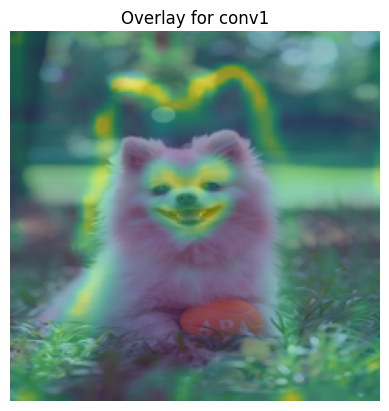

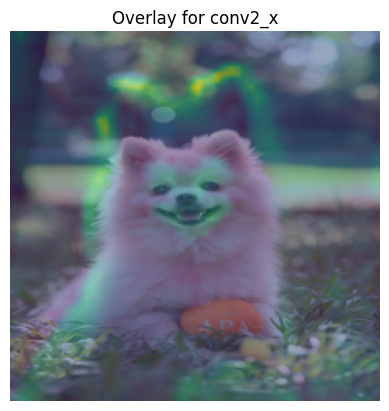

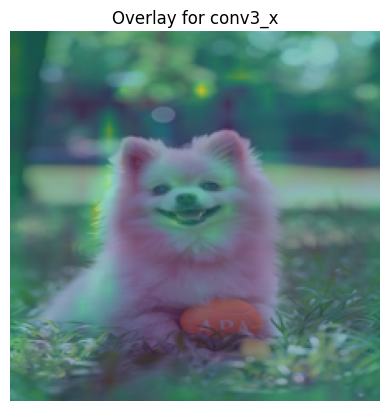

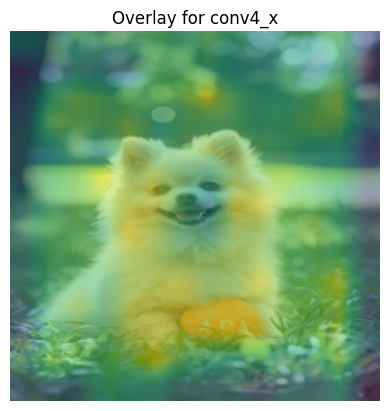

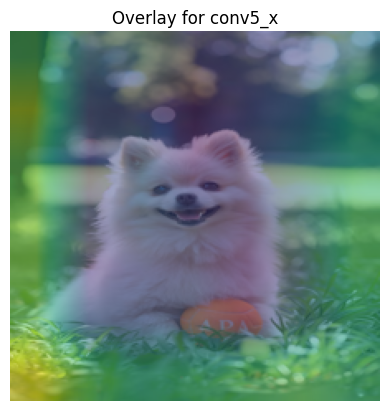

In [50]:
# 특징 맵 오버레이 시각화
image_resized = image.resize((224, 224))
image_np = np.array(image_resized)

for layer_name, feature_map in features.items():
    feature_map = feature_map.squeeze().cpu().numpy()
    feature_map_mean = np.mean(feature_map, axis=0)
    heatmap = cv2.resize(feature_map_mean, (224, 224))
    heatmap = np.clip(heatmap, 0, 1)

    plt.imshow(image_np)
    plt.imshow(heatmap, cmap='viridis', alpha=0.5)
    plt.title(f"Overlay for {layer_name}")
    plt.axis('off')
    plt.show()
